#                                        Анализ маркетплейса


# Основные задачи:

Задача 1: Оценить месячный retention в оформление заказа с помощью когортного анализа.

Задача 2: Определить, существует ли product/market fit у этого маркетплейса.

Задача 3: Определить 5 основных метрик, на которых продакту можно сконцентрироваться, чтобы максимизировать прибыль компании.

Задача 4: Выбрать одну из 3 основных гипотез с помощью фреймворка ICE.

Задача 5: Сформулировать нужные метрики, на которые ваша гипотеза должна повлиять.

Задача 6: Сформулировать выводы о проделанной работе. 

-------------------------------------------------------------------------------------------------------------------------------

# Загрузим данные и произведем EDA

In [85]:
# Импортируем нужные библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from operator import attrgetter
from matplotlib import colors as mcolors
import urllib.parse
import requests

%matplotlib inline

In [86]:
# Напишем функцию для обзора датасетов
def df_review (df):
    display(df.head())
    print('--------------------------------------------------------------------------------------------------------------------')
    print(df.info())
    print('--------------------------------------------------------------------------------------------------------------------')
    print(df.shape)
    print('--------------------------------------------------------------------------------------------------------------------')
    print(df.nunique())
    print('--------------------------------------------------------------------------------------------------------------------')
    print(df.describe())
    print('--------------------------------------------------------------------------------------------------------------------')
    print(df.isna().sum())
    print('--------------------------------------------------------------------------------------------------------------------')
    print(df.duplicated().sum())

# olist_customers_dataset.csv — таблица с уникальными идентификаторами пользователей

customer_id — позаказный идентификатор пользователя

customer_unique_id — уникальный идентификатор пользователя (аналог номера паспорта)

customer_zip_code_prefix — почтовый индекс пользователя

customer_city — город доставки пользователя

customer_state — штат доставки пользователя

In [87]:
# Загрузка данных о клиентах
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_url = 'https://disk.yandex.ru/d/YYRsaU1Fy5RiSQ'  
 
# Загрузочная ссылка
final_url = base_url + urllib.parse.urlencode(dict(public_key=public_url)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 

# загружаем в датафрейм
customers = pd.read_csv(download_url)  

In [88]:
# Выведем описательную статистику дф
df_review(customers)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


--------------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None
--------------------------------------------------------------------------------------------------------------------
(99441, 5)
--------------------------------------------------------------------------------------------------------------------
customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    1

In [89]:
# Проверим распределение клиентов по Штатам
customer_state_count =customers\
    .groupby(['customer_state','customer_city'],as_index = False)\
    .agg({'customer_unique_id':'nunique'})\
    .sort_values('customer_unique_id', ascending = False)\
    .head(10)

In [90]:
# Посчитаем долю каждого штата в общем количестве уникальных пользователей.
customer_state_count['customer_unique_rate'] = customer_state_count['customer_unique_id']/customer_state_count['customer_unique_id'].sum()

In [91]:
customer_state_count

,customer_state,customer_city,customer_unique_id,customer_unique_rate
4176,SP,sao paulo,14984,0.443261
2788,RJ,rio de janeiro,6620,0.195835
1062,MG,belo horizonte,2672,0.079044
601,DF,brasilia,2069,0.061206
2406,PR,curitiba,1465,0.043338
3729,SP,campinas,1398,0.041356
3208,RS,porto alegre,1326,0.039226
372,BA,salvador,1209,0.035765
3836,SP,guarulhos,1153,0.034108
4160,SP,sao bernardo do campo,908,0.026861


# Вывод:
1. Типы данных считаны корректно
2. Пропуски и дубликаты отсутсвуют
3. По количесву customer_id - уникальных заказов (99441) и customer_unique_id - уникальных пользователей(96096) можем судить о высоком оттоке пользователей, скорее всего, конверсия в повторный заказ будет крайне мала.
4. Более 40% пользователей из штата Сан-Паулу и его одноименного города. Считаю это корректным, т.к. Сан-Паулу самый населённый и развитый штат страны, а одноименный город является крупнейшим городом Бразилии и всей Южной Америки.

# olist_orders_dataset.csv —  таблица заказов
order_id — уникальный идентификатор заказа (номер чека)

customer_id — позаказный идентификатор пользователя

order_status — статус заказа

order_purchase_timestamp — время создания заказа

order_approved_at — время подтверждения оплаты заказа

order_delivered_carrier_date — время передачи заказа в логистическую службу

order_delivered_customer_date — время доставки заказа

order_estimated_delivery_date — обещанная дата доставки

In [92]:
# Загрузочная ссылка
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_url = 'https://disk.yandex.ru/d/wHpsXAoAbjh47A'  
 
final_url = base_url + urllib.parse.urlencode(dict(public_key=public_url)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 

# загружаем в датафрейм. Судя по описанию данных, в нем имеются даты, поэтому попробуем сразу их спарсить 
orders = pd.read_csv(download_url, parse_dates=[3,4,5,6,7])  

In [93]:
# Выведем описательную статистику дф
df_review(orders)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


--------------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB
None
-----------------------------------------

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  # This is added back by InteractiveShellApp.init_path()
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  # This is added back by InteractiveShellApp.init_path()
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=T

                                order_id                       customer_id  \
count                              99441                             99441   
unique                             99441                             99441   
top     3716cd16bc2a97768309209eb4d4c6a7  2e2efd740af343446e6b2aa4e1480d60   
freq                                   1                                 1   
first                                NaN                               NaN   
last                                 NaN                               NaN   

       order_status order_purchase_timestamp    order_approved_at  \
count         99441                    99441                99281   
unique            8                    98875                90733   
top       delivered      2018-03-31 15:08:21  2018-02-27 04:31:10   
freq          96478                        3                    9   
first           NaN      2016-09-04 21:15:19  2016-09-15 12:16:38   
last            NaN      2018-10-17 17:

In [94]:
# Проверим датасет orders на количество строк, в которых отсутствует время доставки заказа, но статус заказа равен "delivered"
orders[orders['order_delivered_customer_date'].isnull()].query('order_status == "delivered"').shape

(8, 8)

In [95]:
# Запишем данные в переменную
order_id_delet_1 = orders[orders['order_delivered_customer_date'].isnull()].query('order_status == "delivered"').order_id

Заказы, в которых отсутсвует время доставки и статус заказа "delivered" ,считаю багом в данных, поэтому мы можем удалить эти записи.

In [96]:
# Проверим датасет orders на количество строк, в которых отсутствует время подтверждения оплаты, но статус заказа равен "delivered"
orders[orders['order_approved_at'].isnull()].query('order_status == "delivered"').shape

(14, 8)

In [97]:
# Запишем данные в переменную
order_id_delet_2 = orders[orders['order_approved_at'].isnull()].query('order_status == "delivered"').order_id

In [98]:
# Проверим датасет orders на количество строк, в которых  время доставки заказа меньше ,чем время подтверждения оплаты заказа
orders.query('order_delivered_customer_date <order_approved_at').shape

(61, 8)

In [99]:
# Запишем данные в переменную
order_id_delet_3 = orders.query('order_delivered_customer_date <order_approved_at').order_id

In [100]:
# Всего сторок
orders.shape

(99441, 8)

1.Заказ доставлен, но оплаты нет. 2.Дата доставки меньше даты подтверждения заказа. Суммарно эти строки составляют всего 0,08% от общего количества данных, что указывает на отсутствие постоплаты в нашем маркетплейсе, поэтому мы можем удалить эти записи.(Требуется проверка системы подтверждения оплат, возможен сбой)

In [101]:
# Проверим датасет orders на количество строк, в которых отсутствует время передачи заказа в логистическую службу, но статус заказа равен "delivered"
orders[orders['order_delivered_carrier_date'].isnull()].query('order_status == "delivered"').shape

(2, 8)

In [102]:
# Запишем данные в переменную
order_id_delet_4 = orders[orders['order_delivered_carrier_date'].isnull()].query('order_status == "delivered"').order_id

In [103]:
# Проверим датасет orders на количество строк, в которых отсутствует время передачи заказа в логистическую службу, но статус заказа равен "shippered"
orders[orders['order_delivered_carrier_date'].isnull()].query('order_status == "shippered"').shape

(0, 8)

In [104]:
# проверим датасет orders на количество строк, в которых  время доставки заказа меньше ,чем время передачи заказа в логистическую службу
orders.query('order_delivered_customer_date <order_delivered_carrier_date').shape

(23, 8)

In [105]:
# Запишем данные в переменную
order_id_delet_5 = orders.query('order_delivered_customer_date <order_delivered_carrier_date').order_id

Заказы, которые не передали в службу доставки и заказы, которые передали в службу доставки позже, чем доставили покупателю так же считаю багом в данных, поэтому мы можем удалить эти записи.

In [106]:
# Создадим новый датафрейм с отфильтрованными данными.
orders_new  = orders.query('order_id not in @order_id_delet_1 & order_id not in @order_id_delet_2 & \
            order_id not in @order_id_delet_3 & order_id not in @order_id_delet_4 & order_id not in @order_id_delet_5')

In [107]:
# Разбивка по полю order_status в процентном соотношении

orders_new.groupby('order_status').order_id.count().div(orders_new.shape[0]).mul(100).round(3)

order_status
approved        0.002
canceled        0.629
created         0.005
delivered      97.017
invoiced        0.316
processing      0.303
shipped         1.114
unavailable     0.613
Name: order_id, dtype: float64

# Вывод:
1. Типы данных считаны корректно
2. Дубликаты отсутсвуют
3. Число заказов сответсвует датафрейму customers(99441).
4. Пропуски в полях order_approved_at, order_delivered_carrier_date, order_delivered_customer_date проанализированы и скорректированы.
5. Высокая доля доставленных заказов 97%
6. Количество отмененных заказов ~ 1.3%

# olist_order_items_dataset.csv — товарные позиции, входящие в заказы
order_id — уникальный идентификатор заказа (номер чека)

order_item_id — идентификатор товара внутри одного заказа

product_id — ид товара (аналог штрихкода)

seller_id — ид производителя товара

shipping_limit_date — максимальная дата доставки продавцом для передачи заказа партнеру по логистике

price — цена за единицу товара

freight_value — вес товара 

# Уникальные статусы заказов в таблице olist_orders_dataset:

created — создан;
approved — подтверждён;
invoiced — выставлен счёт;
processing — в процессе сборки заказа;
shipped — отгружён со склада;
delivered — доставлен пользователю;
unavailable — заказ отменён по причине недоступности товара;
canceled — отменён.

In [108]:
# Загрузочная ссылка
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_url = 'https://disk.yandex.ru/d/0nhiZwlHU1Rumg'  
 
final_url = base_url + urllib.parse.urlencode(dict(public_key=public_url)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 

# загружаем в датафрейм
order_items = pd.read_csv(download_url, parse_dates=[4])  

In [109]:
# Выведем описательную статистику дф
df_review(order_items)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


--------------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB
None
--------------------------------------------------------------------------------------------------------------------
(112650, 7)
------------------------------------

In [110]:
# В данном датафрейме отсутсвует информация о 775 заказах
orders.order_id.nunique() - order_items.order_id.nunique()

775

In [111]:
# Выведем топ продаваемых позиций
order_items\
    .groupby('product_id',as_index = False)\
    .agg({'order_item_id':'count'})\
    .sort_values('order_item_id',ascending = False)\
    .head(10)

,product_id,order_item_id
22112,aca2eb7d00ea1a7b8ebd4e68314663af,527
19742,99a4788cb24856965c36a24e339b6058,488
8613,422879e10f46682990de24d770e7f83d,484
7364,389d119b48cf3043d311335e499d9c6b,392
7079,368c6c730842d78016ad823897a372db,388
10840,53759a2ecddad2bb87a079a1f1519f73,373
27039,d1c427060a0f73f6b889a5c7c61f2ac4,343
10867,53b36df67ebb7c41585e8d54d6772e08,323
2794,154e7e31ebfa092203795c972e5804a6,281
8051,3dd2a17168ec895c781a9191c1e95ad7,274


# Вывод:
1. Типы данных считаны корректно
2. Дубликаты отсутсвуют
3. Число заказов не сответсвует датафрейму orders. Отсутвуют записи о 775 заказа. Возможен баг в подгрузке данных или обработке заказов
4. Пользователи заказывают различные товары, перекосов на один из товаров нет.

-------------------------------------------------------------------------------------------------------------------------------

# Задача 1. Оценить месячный retention в оформление заказа с помощью когортного анализа.

In [112]:
# Смерджим два датафрейма и отберем нужные данные.Возьмем только доставленные заказы.
data_cohort = pd\
.merge(orders_new.query('order_status == "delivered"'), customers, on = ['customer_id','customer_id'], how = 'inner')[['customer_unique_id','order_approved_at']]

In [113]:
data_cohort.head()

,customer_unique_id,order_approved_at
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 11:07:15
1,af07308b275d755c9edb36a90c618231,2018-07-26 03:24:27
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:55:23
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:45:59
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 22:20:29


In [114]:
# Извлекаем месяц и день заказа
data_cohort['order_period'] = data_cohort['order_approved_at'].dt.to_period('M')
data_cohort['order_period_day'] = data_cohort['order_approved_at'].dt.to_period('D')

In [115]:
data_cohort.head()

,customer_unique_id,order_approved_at,order_period,order_period_day
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 11:07:15,2017-10,2017-10-02
1,af07308b275d755c9edb36a90c618231,2018-07-26 03:24:27,2018-07,2018-07-26
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:55:23,2018-08,2018-08-08
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:45:59,2017-11,2017-11-18
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 22:20:29,2018-02,2018-02-13


In [116]:
# Рассчитаем когорты на основе даты первого действия
data_cohort['cohort'] = data_cohort.groupby('customer_unique_id')['order_approved_at'].transform('min').dt.to_period('M')
data_cohort['cohort_day'] = data_cohort.groupby('customer_unique_id')['order_approved_at'].transform('min').dt.to_period('D')

In [117]:
data_cohort.head()

,customer_unique_id,order_approved_at,order_period,order_period_day,cohort,cohort_day
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 11:07:15,2017-10,2017-10-02,2017-09,2017-09-04
1,af07308b275d755c9edb36a90c618231,2018-07-26 03:24:27,2018-07,2018-07-26,2018-07,2018-07-26
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:55:23,2018-08,2018-08-08,2018-08,2018-08-08
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:45:59,2017-11,2017-11-18,2017-11,2017-11-18
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 22:20:29,2018-02,2018-02-13,2018-02,2018-02-13


In [118]:
# Рассчитываем номер периода в днях
data_cohort['period_number_month'] = np.floor((data_cohort.order_period_day - data_cohort.cohort_day).apply(attrgetter('n'))/30)

In [119]:
data_cohort.head()

,customer_unique_id,order_approved_at,order_period,order_period_day,cohort,cohort_day,period_number_month
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 11:07:15,2017-10,2017-10-02,2017-09,2017-09-04,0.0
1,af07308b275d755c9edb36a90c618231,2018-07-26 03:24:27,2018-07,2018-07-26,2018-07,2018-07-26,0.0
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:55:23,2018-08,2018-08-08,2018-08,2018-08-08,0.0
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:45:59,2017-11,2017-11-18,2017-11,2017-11-18,0.0
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 22:20:29,2018-02,2018-02-13,2018-02,2018-02-13,0.0


In [120]:
# Агрегируем данные по когортам и рассчитанному номеру периода
data_cohort_copy = data_cohort.groupby(['cohort','period_number_month'])\
    .agg({'customer_unique_id':'nunique'}).reset_index()

In [121]:
data_cohort_copy.head()

,cohort,period_number_month,customer_unique_id
0,2016-09,0.0,1
1,2016-10,0.0,258
2,2016-10,6.0,1
3,2016-10,9.0,1
4,2016-10,11.0,1


In [122]:
# Создаем сводную таблицу для когортного анализа
cohort_pivot = data_cohort_copy.pivot_table(index = 'cohort', columns = 'period_number_month',values = 'customer_unique_id')

In [123]:
cohort_pivot

period_number_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,19.0,20.0,21.0
cohort,,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,258.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,...,1.0,NaN,1.0,NaN,1.0,NaN,1.0,2.0,1.0,1.0
2016-12,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,683.0,2.0,NaN,4.0,1.0,1.0,2.0,2.0,NaN,NaN,...,4.0,3.0,2.0,NaN,2.0,2.0,2.0,1.0,NaN,NaN
2017-02,1610.0,2.0,3.0,6.0,4.0,2.0,4.0,1.0,1.0,4.0,...,6.0,1.0,3.0,2.0,1.0,1.0,3.0,NaN,NaN,NaN
2017-03,2509.0,7.0,12.0,11.0,3.0,2.0,8.0,5.0,6.0,6.0,...,4.0,4.0,3.0,6.0,3.0,3.0,2.0,NaN,NaN,NaN
2017-04,2232.0,8.0,6.0,NaN,6.0,8.0,6.0,10.0,5.0,5.0,...,3.0,NaN,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN
2017-05,3451.0,14.0,14.0,9.0,13.0,11.0,11.0,5.0,11.0,9.0,...,10.0,6.0,3.0,7.0,4.0,NaN,NaN,NaN,NaN,NaN
2017-06,3043.0,12.0,15.0,11.0,5.0,16.0,8.0,6.0,4.0,9.0,...,10.0,3.0,9.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
# Рассчитываем размеры когорт(первый столбец сводной таблицы)
cohort_size = cohort_pivot.iloc[:, 0]

In [125]:
# Вычисляем коэффициент удержания, деля на размер коготы
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

In [126]:
retention_matrix

period_number_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,19.0,20.0,21.0
cohort,,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,NaN,NaN,NaN,NaN,NaN,0.003876,NaN,NaN,0.003876,...,0.003876,NaN,0.003876,NaN,0.003876,NaN,0.003876,0.007752,0.003876,0.003876
2016-12,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.002928,NaN,0.005857,0.001464,0.001464,0.002928,0.002928,NaN,NaN,...,0.005857,0.004392,0.002928,NaN,0.002928,0.002928,0.002928,0.001464,NaN,NaN
2017-02,1.0,0.001242,0.001863,0.003727,0.002484,0.001242,0.002484,0.000621,0.000621,0.002484,...,0.003727,0.000621,0.001863,0.001242,0.000621,0.000621,0.001863,NaN,NaN,NaN
2017-03,1.0,0.002790,0.004783,0.004384,0.001196,0.000797,0.003189,0.001993,0.002391,0.002391,...,0.001594,0.001594,0.001196,0.002391,0.001196,0.001196,0.000797,NaN,NaN,NaN
2017-04,1.0,0.003584,0.002688,NaN,0.002688,0.003584,0.002688,0.004480,0.002240,0.002240,...,0.001344,NaN,0.000896,0.000896,0.000896,0.000896,NaN,NaN,NaN,NaN
2017-05,1.0,0.004057,0.004057,0.002608,0.003767,0.003187,0.003187,0.001449,0.003187,0.002608,...,0.002898,0.001739,0.000869,0.002028,0.001159,NaN,NaN,NaN,NaN,NaN
2017-06,1.0,0.003943,0.004929,0.003615,0.001643,0.005258,0.002629,0.001972,0.001314,0.002958,...,0.003286,0.000986,0.002958,0.001314,NaN,NaN,NaN,NaN,NaN,NaN


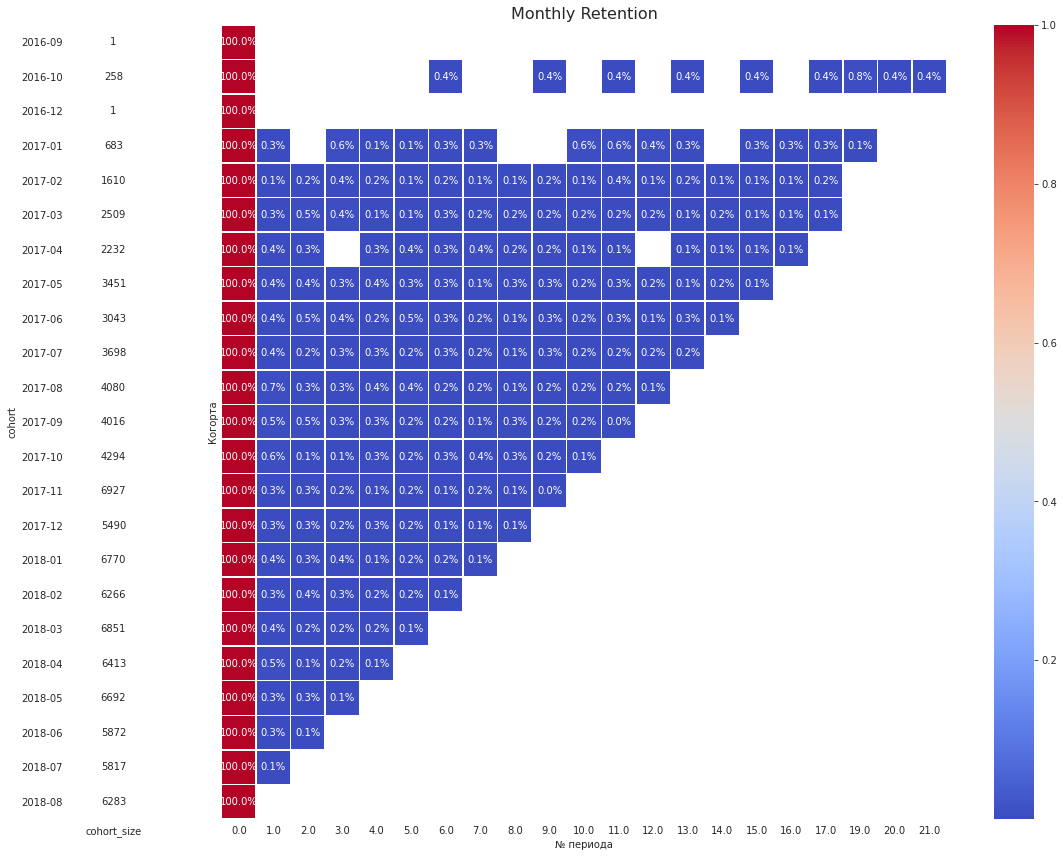

In [127]:
# Строим тепловую карту когортного анализа
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(16, 12), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # Тепловая карта для коэффициентов удержания
    sns.heatmap(retention_matrix,
                mask=retention_matrix.isnull(),
                annot=True,
                fmt='.1%',
                linewidth=.5,
                cmap='coolwarm',
                square=True,
                ax=ax[1])
    ax[1].set_title('Monthly Retention', fontsize=16)
    ax[1].set(xlabel='№ периода', ylabel='Когорта')

    # Тепловая карта для размеров когорт
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
                annot=True,
                cbar=False,
                fmt='g',
                cmap=white_cmap,
                ax=ax[0])

    fig.tight_layout()
    plt.show()

In [128]:
# Рассчитаем медианный retention 1-го месяца.
median_retention = round(retention_matrix.iloc[:, 1].median(),4)
median_retention

0.0035

# Вывод:
1. Для расчета retention были использованы заказы со статусом 'delivered'
2. Медианные retention 1-го месяца равен 0.0035
3. Максимальный retention на 3й месяц зафиксирован в январской когорте 2017 года 
4. Показатели свидетельствуют о высоком оттоке пользователей после первого заказа

-------------------------------------------------------------------------------------------------------------------------------

# Задача 2. Определить, существует ли product/market fit у маркетплейса.

In [129]:
# Определим медианное значение retention за каждый период
retention_median = retention_matrix.median().to_frame().reset_index().rename(columns={0: 'median_retention'})

In [130]:
retention_median.median()

period_number_month    10.000000
median_retention        0.002391
dtype: float64

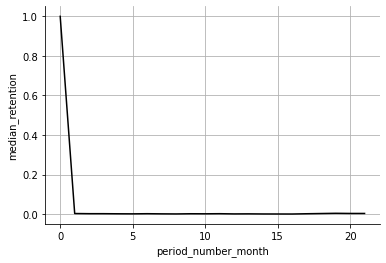

In [131]:
# Визуализируем retention curve
fig,ax = plt.subplots(figsize = (6,4))
fig = sns.lineplot(data=retention_median, x='period_number_month', y='median_retention',color = '0')
fig = plt.grid(which='major')
sns.despine()

Исходя из когортного анализа и графика выше, можно сделать следующие выводы:

2016-10 был пробный запуск приложения. В 2017-01 был оф. релиз, начали привлекать клиентскую базу.
Мы можем наблюдать активный рост платящей аудитории до 2017-11, после же метрика Paying Users вышла на плато.

Retention хоть и выходит на плато, но его показатель крайне низок ~ 0.0023 , после первой покупки пользователи не возвращаются, это может говорить о том, что продукт не оправдал их ожидание или они не считают его полезным. Сделаем вывод, что у продукта отсутсует PMF.

Нам стоит выбрать ключевые метрики и отслеживать их для понимания состояния продукта. Сделать уклон на удержание и вовлеченность пользователей в продукт. Рассмотреть и оценить жизненный цикл клиента, определить на каком этапе они отваливаются.

-------------------------------------------------------------------------------------------------------------------------------

# Задача 3. Определить 5 основных метрик, на которых продакт может сконцентрироваться, чтобы максимизировать прибыль компании.

1. Первая метрика должна отражать рост объёма продаж маркетплейса.
2. Вторая — показывать объем аудитории, которой продукт доставляет ценность.
3. Третья — отражать заинтересованность новых клиентов в продукте.
4. Четвёртая — отражать вовлеченность клиента в продолжение использования продукта.
5. Пятая — отражать денежное выражение вовлеченности клиента.

# Для начала определимся с метриками :
1. GMV (Gross Merchandise Value) - позволит оценить общий объем продаж на маркетплейсе за календарный месяц.
2. MAU (Monthly Active Users) - позволит оценить общий объем аудитории на маркетплейсе за календарный месяц, которой продукт доставляет ценность (будем считать пользователей, которые сделали  2 и более заказа)
3. NAU (New Active Users) - позволит оценить объем новых клиентов на маркетплейсе за календарный месяц, которые заинтересованы в продукте.(активным будем считать клиента, который сделал хотя бы 1 заказ)
4. RETENTION RATE - позволит оценить вовлеченность клиента в продолжение использования продукта.
5. ARPPU (Average Revenue Paying  Per User) - позволит оценить среднюю сумму денег, которую каждый пользователь тратит на маркетплейсе за месяц.


In [132]:
# Смерджим датафреймы в один итоговый для дальнейшей работы
Df = pd.merge(order_items, orders_new, on = ['order_id','order_id'], how = 'inner')
Df_full = pd.merge(Df, customers, on = ['customer_id','customer_id'], how = 'inner')

In [133]:
Df_full.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP


In [134]:
# Добавим столбец с месяцем заказа и днем
Df_full['Month_date'] = Df_full['order_purchase_timestamp'].dt.to_period('M')
Df_full['Day_date'] = Df_full['order_purchase_timestamp'].dt.to_period('D')
Df_full.Month_date=Df_full.Month_date.astype(str)    

In [135]:
# Проверим, сколько дней бы работал маркетплейс в каждом месяце
Df_full\
    .groupby('Month_date',as_index = False)\
    .agg({'Day_date':'nunique'})

,Month_date,Day_date
0,2016-09,3
1,2016-10,9
2,2016-12,1
3,2017-01,27
4,2017-02,28
5,2017-03,31
6,2017-04,30
7,2017-05,31
8,2017-06,30
9,2017-07,31


предлагаю убрать из датафрейма иформацию о месяцах до 2017-01 и после 2018-08, т.к в эти месяца было недостаточное количество рабочих дней

In [136]:
# Отфильтруем датафрейм
Df_full = Df_full.query('Month_date >"2016-12" & Month_date <"2018-09"')

# GMV (Gross Merchandise Value)

In [137]:
# Рассчитаем GMV для каждого месяца
GMV = Df_full\
    .query('order_status not in ["unavailable","canceled"]')\
    .groupby('Month_date',as_index = False)\
    .agg({'price':'sum'})\
    .rename(columns = {'price':'GMV'})

In [138]:
# Добавим скользящее среднее для визуализации тренда
GMV['rm_4'] = GMV.GMV.rolling(4, min_periods=1).mean()

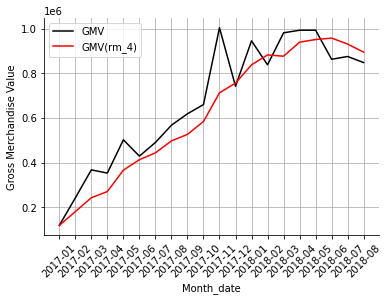

In [139]:
# Построим график линейный график GMV по месяцам
fig,ax = plt.subplots(figsize = (6,4))

fig = sns.lineplot(data =GMV, x = 'Month_date' , y = 'GMV',color = '0' )
fig = sns.lineplot(data =GMV, x = 'Month_date' , y = 'rm_4',color = 'red' )
fig = plt.xticks (rotation = 45)
fig = plt.grid(which='major')
plt.legend(labels = ['GMV','GMV(rm_4)'])
ax.set_xlabel('Month_date')
ax.set_ylabel('Gross Merchandise Value')
sns.despine()

# Вывод:
Обратим внимание, что с 2018-04 GMV сниженижается и возможно выйдет на плато. Скорее всего, это связано с низким retention

# MAU (Monthly Active Users) 

In [140]:
# Рассчитаем MAU для каждого месяца
MAU =Df_full\
    .groupby(['Month_date','customer_unique_id'],as_index = False)\
    .agg({'order_id':'nunique'})\
    .rename(columns = {'order_id':'unique_orders'})\
    .query('unique_orders >=2')\
    .groupby('Month_date',as_index = False)\
    .agg({'customer_unique_id':'nunique'})\
    .rename(columns = {'customer_unique_id':'MAU'})

In [141]:
# рассчитаем уникальных пользователей по месяцам
unique_customers = Df_full\
    .groupby('Month_date',as_index = False)\
    .agg({'customer_unique_id':'nunique'})\
    .sort_values('customer_unique_id',ascending = False)
    

In [142]:
# Посчитаем, какую в среднем долю занимают пользователи, сделавшие 2 и более заказа, в общем числе уникальных пользователей.
customer_for_month = pd.merge(unique_customers,MAU,on = ['Month_date','Month_date'], how = 'inner')
customer_for_month['mau_rate'] = customer_for_month['MAU']/customer_for_month['customer_unique_id']  * 100
customer_for_month['mau_rate'].mean().round(3)

1.457

In [143]:
# На графике много пиковых значений, добавим скользящее среднее для визуализации тренда
MAU['rm_3'] = MAU.MAU.rolling(3, min_periods=1).mean()

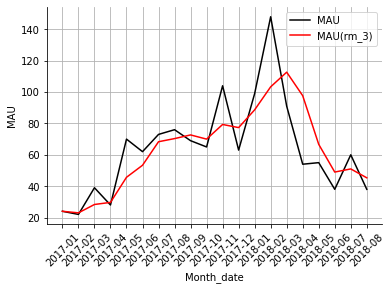

In [144]:
# Построим график линейный график MAU по месяцам
fig,ax = plt.subplots(figsize = (6,4))

fig = sns.lineplot(data = MAU, x = 'Month_date', y = 'MAU', color = '0')
fig = sns.lineplot(data = MAU, x = 'Month_date', y = 'rm_3', color='red')
fig = plt.xticks(rotation = 45)
fig = plt.grid(which = 'major')
plt.legend(labels = ['MAU','MAU(rm_3)'])
ax.set_xlabel('Month_date')
ax.set_ylabel('MAU')

sns.despine()

# Вывод:
1. В среднем аудитория, которой продукт доставляет ценность(пользователи, сделавшие 2 и более заказа) , составляет 1,4% от общего числа уникальных пользователей за месяц.Эти показатели очень малы.
2. На графике мы видем стремительное падение с 2018-03. Считаю это связнным с низким уровнем retention и отсутствием PMF у продукта.

# NAU (New Active Users)

In [145]:
# Рассчитаем NAU для каждого месяца
NAU =Df_full\
    .groupby('customer_unique_id',as_index = False)\
    .agg({'Month_date':'min'})\
    .groupby('Month_date',as_index = False)\
    .agg({'customer_unique_id':'nunique'})\
    .rename(columns = {'customer_unique_id':'NAU'})

In [146]:
# Добавим скользящее среднее для визуализации тренда
NAU['rm_3'] = NAU.NAU.rolling(3, min_periods=1).mean()

Text(0, 0.5, 'NAU')

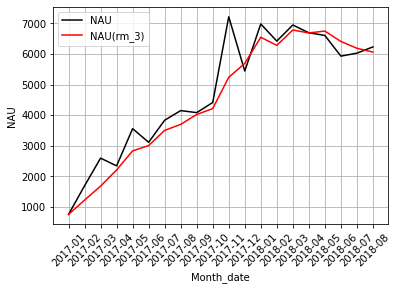

In [147]:
# Построим график линейный график NAU по месяцам
fig,ax = plt.subplots(figsize = (6,4))
fig = sns.lineplot(data = NAU, x = 'Month_date' , y = 'NAU', color = '0' )
fig = sns.lineplot(data = NAU, x = 'Month_date' , y = 'rm_3', color = 'red' )
fig = plt.xticks(rotation = 45)
fig = plt.grid(which = 'major')
plt.legend(labels = ['NAU','NAU(rm_3)'])
ax.set_xlabel('Month_date')
ax.set_ylabel('NAU')

# Вывод:
с 2018-05 наблюдается снижение количества новой платящей аудитории. До этого месяца NAU стремительно росло. Можем сделать вывод, что NAU выходит на плато, из-за чего мы не сможем прирастать GMV.

# RETENTION RATE 

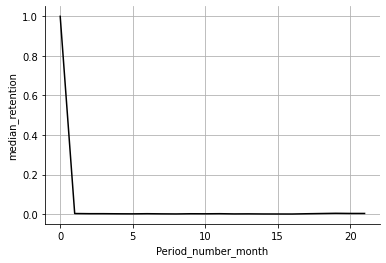

In [148]:
#График retention мы уже строили, скопируем.
fig,ax = plt.subplots(figsize = (6,4))
fig = sns.lineplot(data=retention_median, x='period_number_month', y='median_retention',color = '0')
fig = plt.grid(which='major')
ax.set_xlabel('Period_number_month')
ax.set_ylabel('median_retention')
sns.despine()

# ВЫВОД
Retention хоть и выходит на плато, но его показатель крайне низок ~ 0.0023 , после первой покупки пользователи не возвращаются, это может говорить о том, что продукт не оправдал их ожидание или они не считают его полезным. Сделаем вывод, что у продукта отсутсует PMF.

# ARPPU (Average Revenue Paying  Per User)

In [149]:
# Рассчитаем ARPPU для каждого месяца
ARPPU = Df_full\
    .query('order_status not in ["unavailable","canceled"]')\
    .groupby('Month_date',as_index = False)\
    .agg(total_revenue = ('price','sum'),unique_customers = ('customer_unique_id','nunique'))
ARPPU['ARPPU'] = (ARPPU['total_revenue']/ARPPU['unique_customers']).round(2)

In [150]:
ARPPU

,Month_date,total_revenue,unique_customers,ARPPU
0,2017-01,119823.73,751,159.55
1,2017-02,242868.32,1678,144.74
2,2017-03,368252.32,2576,142.96
3,2017-04,353842.98,2345,150.89
4,2017-05,502690.21,3567,140.93
5,2017-06,429709.72,3140,136.85
6,2017-07,490687.40,3861,127.09
7,2017-08,567774.00,4189,135.54
8,2017-09,619061.43,4145,149.35
9,2017-10,660179.62,4481,147.33


In [151]:
# Добавим скользящее среднее для визуализации тренда
ARPPU['rm_5'] = ARPPU.ARPPU.rolling(5, min_periods = 1).mean()

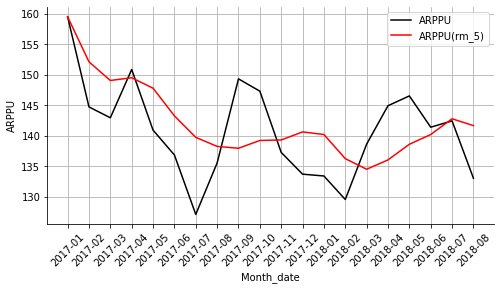

In [152]:
# Построим график линейный график ARPPU по месяцам
fig,ax = plt.subplots(figsize = (8,4))
fig = sns.lineplot(data=ARPPU, x='Month_date', y='ARPPU',color = '0')
fig = sns.lineplot(data=ARPPU, x='Month_date', y='rm_5',color = 'red')
fig = plt.xticks(rotation = 45)
fig = plt.grid(which='major')
plt.legend(labels = ['ARPPU','ARPPU(rm_5)'])
ax.set_xlabel('Month_date')
ax.set_ylabel('ARPPU')
sns.despine()

# ВЫВОД
ARPPU в начале запуска было пиковое значение 159, после снизился и держится в пределах 130-145

Используя данные метрики, мы видим обороты нашего маркетплейса, вовлеченность пользователей, уровень их удержания,количество новых пользователей, которые сделали первый заказ, а так же среднюю выручку с одного пользователя.

Стоит обратить внимание на низкий уровень удержания, пользователи уходят после первого заказа. Пересмотреть маркетинговые стратегии, т.к приток NAU снижается или выходит на плато.
Нужно продожлать отслеживать ключевые метрики,для точного утвержения выше сказанных проблем.

-------------------------------------------------------------------------------------------------------------------------------

# Задача 4. Выбрать одну из 3 основных гипотез с помощью фреймворка ICE.

Оценив когортный анализ и метрики, мы решили внести изменения в продукт. Были сформулированы 3 гипотезы. Применим фреймворк ICE и выберем одну из трех основных гипотез. Показатели по Ease, Confidence уже заполнены командой. Требуется оценить Impact от влияния наших гипотез

- гипотеза 1 :Impact - ? , Confidence - 8, Ease - 6
- гипотеза 2 :Impact - ? , Confidence - 10, Ease - 4  
- гипотеза 3 :Impact - ? , Confidence - 9, Ease - 5  

# Шкала
Impact	\ Значение метрики
- 1 -  0 - 50
- 2	-  51 - 150
- 3	-  151 - 350
- 4	-  351 - 750
- 5	-  751 - 1550
- 6	-  1551 - 3150
- 7	-  3151 - 6350
- 8	-  6351 - 12750
- 9	-  12751 - 25550
- 10 -  25551 - 51 150
										

In [153]:
# Смерджим датафреймы в один итоговый для дальнейшей работы, не исключая из него баги.
hypothesis = pd.merge(orders, order_items, on = ['order_id','order_id'], how = 'left')
hypothesis_full = pd.merge(hypothesis, customers, on = ['customer_id','customer_id'], how = 'left')

In [154]:
# Добавим столбец с месяцем
hypothesis_full['month_date'] = hypothesis_full.order_purchase_timestamp.dt.to_period('M')

In [155]:
#Подготовим данные отберем заказы с июня 2017
hypothesis_full_copy = hypothesis_full.query('month_date > "2017-05"')

# Гипотеза 1 : 
Если исправим баг в системе процессинга заказов, то клиентам не придётся сталкиваться с проблемой отмены заказа, вследствие чего количество доставленных заказов увеличится. Считаем, что мы таким образом избавимся от всех отмен.	

Баг в системе процессинга, может быт на любом этапе, начиная от момента, когда клиент размещает заказ, и заканчивая его выполнением и доставкой. 

Исходя из статуса заказов у нас есть 2 категории отмененных товаров. 
- 1. Заказы, отмененные по неизвесной причине (canceled)
- 2. Заказы, отмененные по причине недоступности товара (unavailable )

Отфильтруем записи с нужным нам статусом и проверим кол-во этих заказов.

In [156]:
# Отберем все отмененные заказы.
df_impact_1  = hypothesis_full_copy.query('order_status == "unavailable" or order_status == "canceled" ')
print(f'По причине бага в системе процессинга заказов было отменено {df_impact_1.shape[0]} заказа')

По причине бага в системе процессинга заказов было отменено 1032 заказа


In [157]:
# Определим Impact по шкале для первой гипотезы и рассчитаем ICE.
Impact_1 = 5
Confidence_1 = 8
Ease_1 = 6

ICE_1 = Impact_1 * Confidence_1 * Ease_1 
print(f'ICE-score для Гипотезы 1 составляет {ICE_1}')

ICE-score для Гипотезы 1 составляет 240


# Гипотеза 2 :
Если сократим время до отгрузки заказа, то клиенты перестанут получать свой заказ с запаздыванием, вследствие чего количество заказов увеличится за счёт повторных заказов. 

Для рассчета impact по этой гипотезе, нужно отобрать все  заказы, которые пришли позже ожидаемого срока

In [158]:
# Филтруем дф по заказам с задержкой
orders_with_delays = hypothesis_full_copy.query('order_delivered_customer_date>order_estimated_delivery_date ')

In [159]:
# Посмотрим на статусы заказов
orders_with_delays.order_status.unique()

array(['delivered', 'canceled'], dtype=object)

Некоторые пользователи не дожидались заказов и отменяли их

In [160]:
# Посмотрим сколько всего таких заказов
orders_with_delays.shape[0]

8114

Так как гипотеза завязана на повторных заказах, рассчитаем количество повторных заказов из заказов с задержкой.

In [161]:
# Зная медианный retention рассчитаем кол-во повторных заказов
repeated_orders = (orders_with_delays.shape[0] * median_retention).round()
f'Повторных заказов будет {repeated_orders} '

'Повторных заказов будет 28.0 '

In [162]:
# Определим Impact по шкале для второй гипотезы и рассчитаем ICE
Impact_2 = 1
Confidence_2 = 10
Ease_2 = 4

ICE_2 = Impact_2 * Confidence_2 * Ease_2 
print(f'ICE-score для Гипотезы 1 составляет {ICE_2}')

ICE-score для Гипотезы 1 составляет 40


# Гипотеза 3 :
Если создадим новый способ оплаты, который будет конвертировать клиентов в повторный заказ, то клиенты не будут испытывать трудности при оформлении заказа, вследствие чего количество заказов увеличится за счёт повторных заказов.

Для этой гипотезы, нужно взять клиентов, которые отменили неоплаченный заказ(так мы поймем, кто отвалился на этапе оплаты).

In [163]:
# Отберем заказы, отмененные на этапе оплаты.
payment_problem_orders = hypothesis_full_copy[hypothesis_full_copy['order_approved_at']\
                                              .isnull()].query('order_status == "canceled"')
f'Количество заказов, отмененных на этапе оплаты {payment_problem_orders.shape[0]} '

'Количество заказов, отмененных на этапе оплаты 117 '

In [164]:
# Зная медианный retention рассчитаем кол-во повторных заказов
repeated_orders_2 = (payment_problem_orders.shape[0] * median_retention).round()
f'Повторных заказов будет {repeated_orders_2} '

'Повторных заказов будет 0.0 '

In [165]:
# Определим Impact по шкале для третьей гипотезы и рассчитаем ICE
Impact_3 = 1
Confidence_3 = 9
Ease_3 = 5

ICE_3 = Impact_3 * Confidence_3 * Ease_3
print(f'ICE-score для Гипотезы 1 составляет {ICE_3}')

ICE-score для Гипотезы 1 составляет 45


# Вывод
По итогам рассчета фреймворка ICE, приоритетной для нас стала гипотеза 1 :
- Если исправим баг в системе процессинга заказов, то клиентам не придётся сталкиваться с проблемой отмены заказа, вследствие чего количество доставленных заказов увеличится. Считаем, что мы таким образом избавимся от всех отмен.	

По рассчетам мы сохраним в нашем продукте 1032 отмененных заказа. ICE = 240.

-------------------------------------------------------------------------------------------------------------------------------

# Задача 5. Сформулировать нужные метрики, на которые ваша гипотеза должна повлиять.

Сформулировать метрики в категории: целевые, прокси, guardrail, на которые должна повлиять выбранная вами гипотеза.

В качестве целевых метрик выберем:

1. Количество доставленных заказов(delivery_orders) - Это основная метрика, которая будет показывать, насколько исправление бага повлияло на успешное выполнение заказов.

2. Доля отмененных заказов (cancel_rate) - Ожидаем, что после изменения эта метрика снизится.

В качестве прокси метрик выберем:

1. Количество обращений в службу поддержки - если клиенты отменяют заказы из-за багов в процессинге, то после исправления, количество обращений должно снизиться.

В качестве guardrail метрик выберем:

1. Время выполнения заказа - если время выполнения увеличится, отсносительно медианного времени за опр. период, то удовлетворенность пользоватлей будет снижаться.
2. Число возвратов товаров -   увеличение числа возвратов может свидетельствовать о потенциальных проблемах с качеством продукции.

-------------------------------------------------------------------------------------------------------------------------------

# Итоговый вывод

# 1. Наблюдается колоссальный отток пользователей.

Медианный retention первого месяца 0.0035. 
Максимальный retention на 3й месяц зафиксирован в когорте 2017-01 и составил всего 0.0058.
Показатели retention держатся ниже 1%,это означает, что пользователи уходят после первого заказа.

# 2. У маркетплейса отсутствует Product/Market Fit

Маркетинговые каналы стабильно привлекают более 3000 платящих пользоватлей,  Retention хоть и выходит на плато, но его показатель крайне низок < 0.5 , после первой покупки пользователи не возвращаются, это может говорить о том, что продукт не оправдал их ожидание или они не считают его полезным. Сделаем вывод, что у продукта отсутсует PMF.

# 4. Гипотезы
Сформулировали 3 гипотезы. Средствам фреймворка ICE, остановились на второй из них :

Если исправим баг в системе процессинга заказов, то клиентам не придётся сталкиваться с проблемой отмены заказа, вследствие чего количество доставленных заказов увеличится. Считаем, что мы таким образом избавимся от всех отмен.

По рассчетам мы сохраним в нашем продукте 1032 отмененных заказа. ICE = 240.

# 4. Гипотезы
Сформулировали 3 гипотезы. Средствам фреймворка ICE, остановились на второй из них :

Если исправим баг в системе процессинга заказов, то клиентам не придётся сталкиваться с проблемой отмены заказа, вследствие чего количество доставленных заказов увеличится. Считаем, что мы таким образом избавимся от всех отмен.

По рассчетам мы сохраним в нашем продукте 1032 отмененных заказа. ICE = 240.

# 5. Для проверки выбранной гипотезы в рамках A/B-тестирования были отобраны следующие метрики:
В качестве целевых метрик выберем:

1. Количество доставленных заказов(delivery_orders) бага повлияло на успешное выполнение заказов.

2. Доля отмененных заказов (cancel_rate) 

В качестве прокси метрик выберем:

1. Количество обращений в службу поддержки 

В качестве guardrail метрик выберем:

1. Время выполнения заказа 
2. Число возвратов товаров

# 6. Рекомендации
- В виду низкого retention и отстутвия PMF, следует оценить качество входящего потока новых клиентов, а так же разработать стратегию по увеличению лояльности со стороны аудитории.
- GMV И NAU показывают падение по тренду, следует обратить внимаее на эти метрики в следующие месяца.
- Контролировать систему процессинга заказов на баги.
- Выстроить систему алертов, для своевременного реагирования на проблему.